# Metric Learning Hyperparameter Optimization

Fine-tuning `EfficientNet-B0` as a classifier worked well, but it’s still worth trying metric learning. In this setup, the final classifier is replaced with a simple linear embedding head.

We tune hyperparameters with Optuna to maximize macro-F1 on the validation set. Evaluation procedure:

1. Train a k-NN on the training embeddings.

2. Test it on the validation embeddings.

This metric-learning-friendly setup encourages an embedding space where samples from the same class cluster together and different classes are pushed apart.

In [1]:
import sys, os
import json
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
from torchvision import models
import optuna
import pandas as pd
from IPython.display import Image, display

from pytorch_metric_learning import losses, miners
from pytorch_metric_learning.samplers import MPerClassSampler

from src.data import get_datasets
from src.utils import set_device, evaluate_knn, EarlyStopper, is_mbconv

In [2]:
# Configurations
DEVICE = set_device()

datasets = get_datasets(root="../data/augmented_images")
output_dir = "../outputs/param-optim-metric"
full_train_ds = datasets["train"]
full_val_ds = datasets["val"]

Device: mps


Four main hyperparameters are tuned in this metric learning process:

1. Learning Rate

2. Triplet Margin

3. Embedding Size

4. Number of Unfrozen Layers

In [3]:
# Define the hyperparameters we want to tune
TUNING_RANGES = {
    "LEARNING_RATE": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "MARGIN": {"type": "float", "low": 0.1, "high": 0.5, "log": False},
    "EMBEDDING_SIZE": {"type": "categorical", "choices": [64, 128, 256]},
    "UNFREEZE_K": {"type": "int", "low": 3, "high": 8},
}

EPOCHS_PER_TRIAL = 7
N_TRIALS = 100

# Sampler settings
M_PER_CLASS = 8
NUM_CLASSES_PER_BATCH = 4
BATCH_SIZE = M_PER_CLASS * NUM_CLASSES_PER_BATCH

## 1. Per-trial training setup

- **Loss:** TripletMarginLoss

- **Miner:** TripletMarginMiner to find hard triplets

- **Optimizer:** AdamW

- **Sampler:** MPerClassSampler to ensure each batch contains multiple examples from a subset of classes

- **Evaluation:** A k-NN classifier is trained on the embeddings of the training set and evaluated on the validation set embeddings. The primary metric is macro-F1

- **Early stopping:** Monitors validation k-NN macro-F1 (mode = max) with patience

In [4]:
def objective(trial):
    """A single training and evaluation run with early stopping."""
    
    # 1. Suggest Hyperparameters for this trial
    params = {}
    for name, p in TUNING_RANGES.items():
        if p['type'] == 'categorical':
            params[name] = trial.suggest_categorical(name, p['choices'])
        elif p['type'] == 'int':
            params[name] = trial.suggest_int(name, p['low'], p['high'])
        elif p['type'] == 'float':
            params[name] = trial.suggest_float(name, p['low'], p['high'], log=p.get('log', False))

    # 2. Setup Model and Training Components
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    in_features = model.classifier[-1].in_features
    model.classifier = nn.Linear(in_features, params['EMBEDDING_SIZE'])
    model.to(DEVICE)
    
    # --- Unfreezing Logic ---
    for p in model.features.parameters(): p.requires_grad = False
    
    mbconv_blocks = [m for m in model.features.modules() if is_mbconv(m)]
    K = min(params['UNFREEZE_K'], len(mbconv_blocks))
    
    for m in mbconv_blocks[-K:]:
        for p in m.parameters(): p.requires_grad = True
    
    for p in model.features[-1].parameters(): p.requires_grad = True
    for p in model.classifier.parameters(): p.requires_grad = True

        
    # --- DataLoaders ---
    pin = torch.cuda.is_available()
    train_sampler = MPerClassSampler(full_train_ds.targets, m=M_PER_CLASS, length_before_new_iter=len(full_train_ds))
    train_loader = torch.utils.data.DataLoader(full_train_ds, sampler=train_sampler, batch_size=BATCH_SIZE, pin_memory=pin)
    gallery_loader = torch.utils.data.DataLoader(full_train_ds, batch_size=128, shuffle=False, pin_memory=pin)
    val_loader = torch.utils.data.DataLoader(full_val_ds, batch_size=128, shuffle=False, pin_memory=pin)

    # --- Metric Learning Components ---
    criterion = losses.TripletMarginLoss(margin=params['MARGIN'])
    miner = miners.TripletMarginMiner(margin=params['MARGIN'], type_of_triplets="hard")
    optimizer = torch.optim.AdamW(model.parameters(), lr=params['LEARNING_RATE'])
    
    # --- Early Stopper Initialization ---
    early_stopper = EarlyStopper(mode="max", patience=3, max_overfit_gap=0.10)
    best_f1_for_trial = 0.0
    best_metrics_for_trial = {} 

    # 3. Training Loop for the trial
    for epoch in range(1, EPOCHS_PER_TRIAL + 1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            embeddings = model(xb)
            hard_triplets = miner(embeddings, yb)
            loss = criterion(embeddings, yb, hard_triplets)
            loss.backward()
            optimizer.step()

        # 4. Evaluation and Reporting
        train_metrics = evaluate_knn(model, gallery_loader, gallery_loader, DEVICE)
        val_metrics = evaluate_knn(model, gallery_loader, val_loader, DEVICE)
        
        train_f1 = train_metrics['f1_macro']
        val_f1 = val_metrics['f1_macro']
        
        # If this epoch is the best so far, save its full metrics dictionary
        if val_f1 > best_f1_for_trial:
            best_f1_for_trial = val_f1
            best_metrics_for_trial = {**val_metrics, 'train_f1_macro': train_f1, 'epoch': epoch}

        # --- Optuna Pruning Logic ---
        trial.report(val_f1, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
        # --- Early Stopping Logic (using F1 scores) ---
        _, should_stop, _ = early_stopper.step(
            val_patience_metric=val_f1,
            train_metric=val_f1,
            val_metric=train_f1
        )
        if should_stop:
            break

    # 5. Attach the best metrics dictionary to the trial object
    trial.set_user_attr("best_metrics", best_metrics_for_trial)
    
    return best_f1_for_trial

## 2. Run the Study
To speed up the process, a `MedianPruner` is used to stop unpromising trials early. The study runs for a set number of trials or until the timeout is reached.

In [5]:
# Silence Optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
optuna.logging.disable_default_handler()

study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())

try:
    study.optimize(objective, n_trials=N_TRIALS, timeout=3600)
except KeyboardInterrupt:
    print("Study interrupted manually.")

print("HYPERPARAMETER TUNING COMPLETE")
print(f"Number of finished trials: {len(study.trials)}")

HYPERPARAMETER TUNING COMPLETE
Number of finished trials: 100


## 3. Results

In [6]:
print("--- Best Trial ---")
best_trial = study.best_trial

print(f"Value (val_f1_macro): {best_trial.value:.4f}")
print("Params: ")

for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

--- Best Trial ---
Value (val_f1_macro): 0.7386
Params: 
    LEARNING_RATE: 0.0006837454494310736
    MARGIN: 0.255336275341413
    EMBEDDING_SIZE: 128
    UNFREEZE_K: 8


In [7]:
print("\n--- Full Metrics for Best Trial ---")
best_metrics = best_trial.user_attrs.get("best_metrics", {})
# Convert metrics to a pandas Series for nice printing
metrics_series = pd.Series(best_metrics)
# Rename keys for clarity and assign the result back
metrics_series = metrics_series.rename(index={'f1_macro': 'val_f1_macro', 'precision_macro': 'val_precision', 'recall_macro': 'val_recall', 'accuracy': 'val_accuracy'})
print(metrics_series.to_string())


--- Full Metrics for Best Trial ---
val_f1_macro      0.738579
val_precision     0.737001
val_recall        0.766621
val_accuracy      0.752336
train_f1_macro    0.875352
epoch             1.000000


In [8]:
file_path = os.path.join(output_dir, "best_metric_hyperparameters.json")
os.makedirs(output_dir, exist_ok=True)

with open(file_path, 'w') as f:
    json.dump(best_trial.params, f, indent=4)

print("Best metric learning hyperparameters are saved!")

Best metric learning hyperparameters are saved!


In [9]:
# --- Create a DataFrame with full results from all trials ---
all_trials = []
for trial in study.trials:
    if trial.state == optuna.trial.TrialState.COMPLETE:
        trial_metrics = trial.user_attrs.get("best_metrics", {})
        # Rename metric keys for clarity in the DataFrame
        renamed_metrics = {
            'val_f1_macro': trial_metrics.get('f1_macro'),
            'val_precision': trial_metrics.get('precision_macro'),
            'val_recall': trial_metrics.get('recall_macro'),
            'val_accuracy': trial_metrics.get('accuracy'),
            'train_f1_macro': trial_metrics.get('train_f1_macro'),
            'epoch': trial_metrics.get('epoch')
        }
        row = {**trial.params, **renamed_metrics}
        all_trials.append(row)

results_df = pd.DataFrame(all_trials)

sorted_df = results_df.sort_values(by="val_f1_macro", ascending=False).reset_index(drop=True)

pd.set_option('display.width', 120)
display(sorted_df.head())

,LEARNING_RATE,MARGIN,EMBEDDING_SIZE,UNFREEZE_K,val_f1_macro,val_precision,val_recall,val_accuracy,train_f1_macro,epoch
0,0.000684,0.255336,128,8,0.738579,0.737001,0.766621,0.752336,0.875352,1
1,0.002139,0.282359,128,6,0.736283,0.736440,0.741159,0.728972,0.840808,1
2,0.001300,0.248982,128,6,0.731823,0.748933,0.730949,0.728972,0.869267,1
3,0.001312,0.219412,128,4,0.724033,0.723101,0.738549,0.733645,0.879899,1
4,0.000418,0.264729,64,6,0.718631,0.718721,0.731312,0.710280,0.870140,1


In [10]:
file_path = os.path.join(output_dir, "metric-hyperparam-optim-results.csv")

sorted_df.to_csv(file_path, index=False)

print("All results are saved!")

All results are saved!


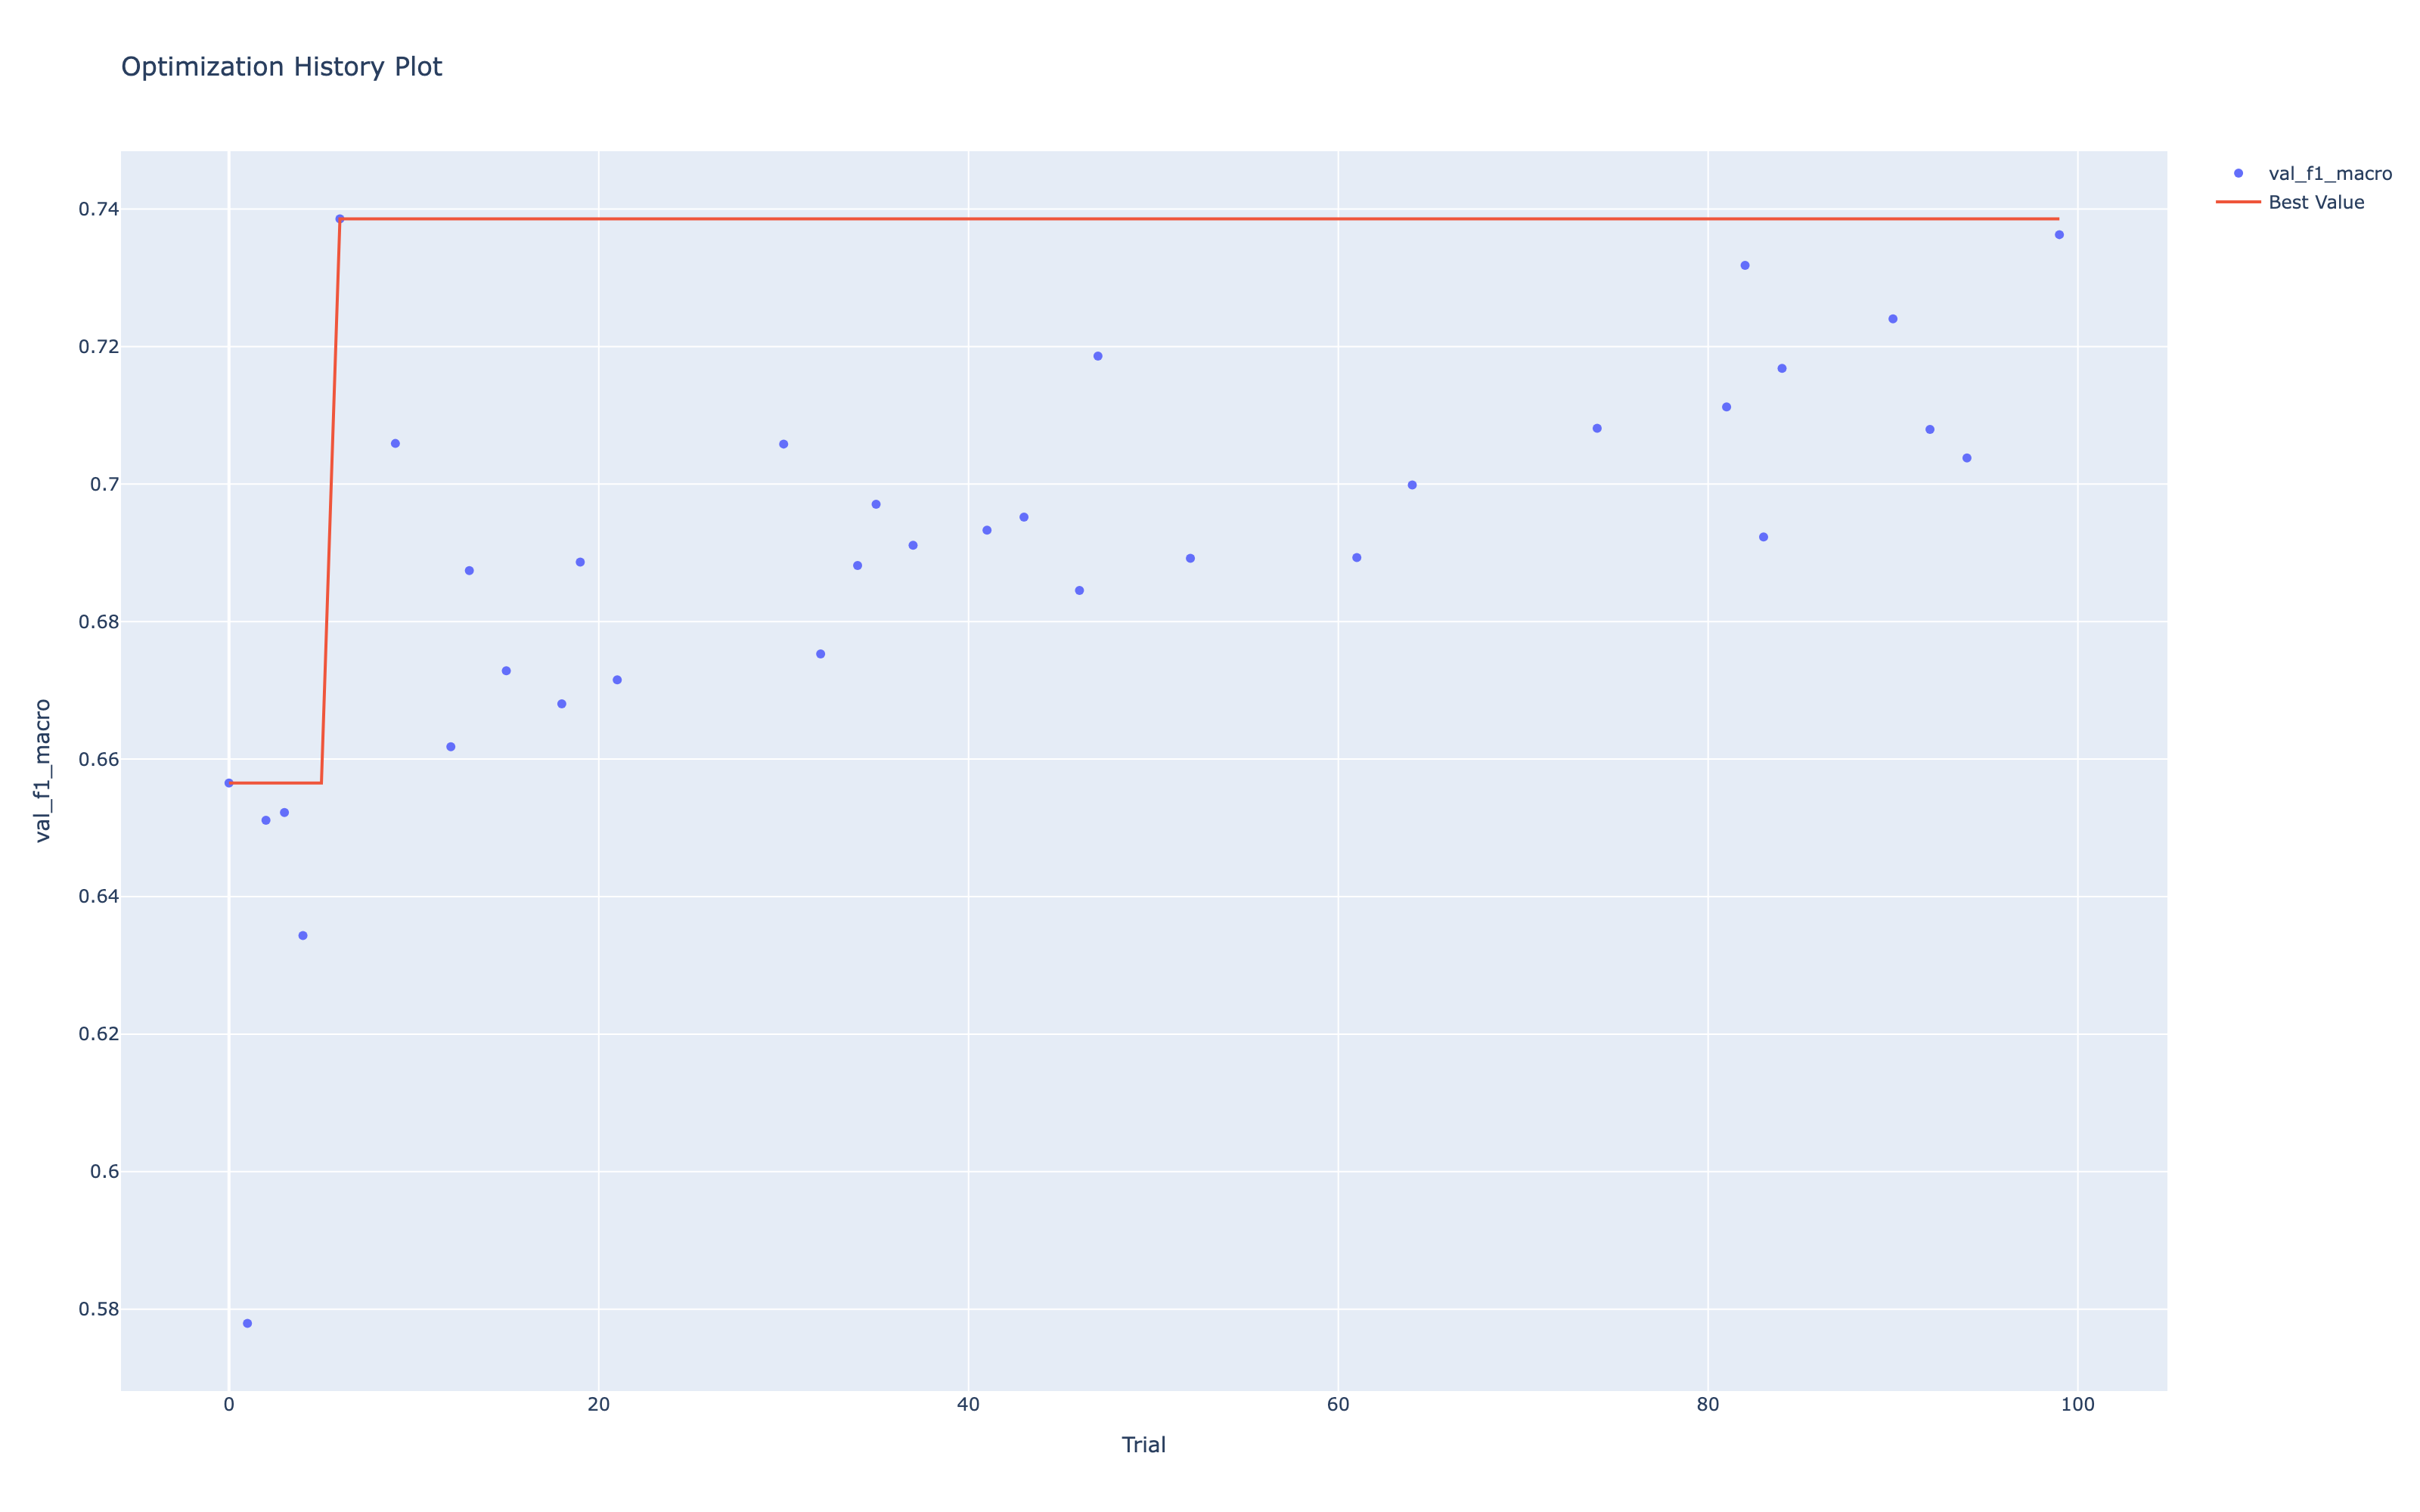

In [11]:
# Shows how the F1-score improved over trials
fig = optuna.visualization.plot_optimization_history(study, target_name="val_f1_macro")
file_path = os.path.join(output_dir, "metric_optimization_history.png")
fig.write_image(file_path, width=1600, height=1000, scale=2)

Image(filename=file_path)

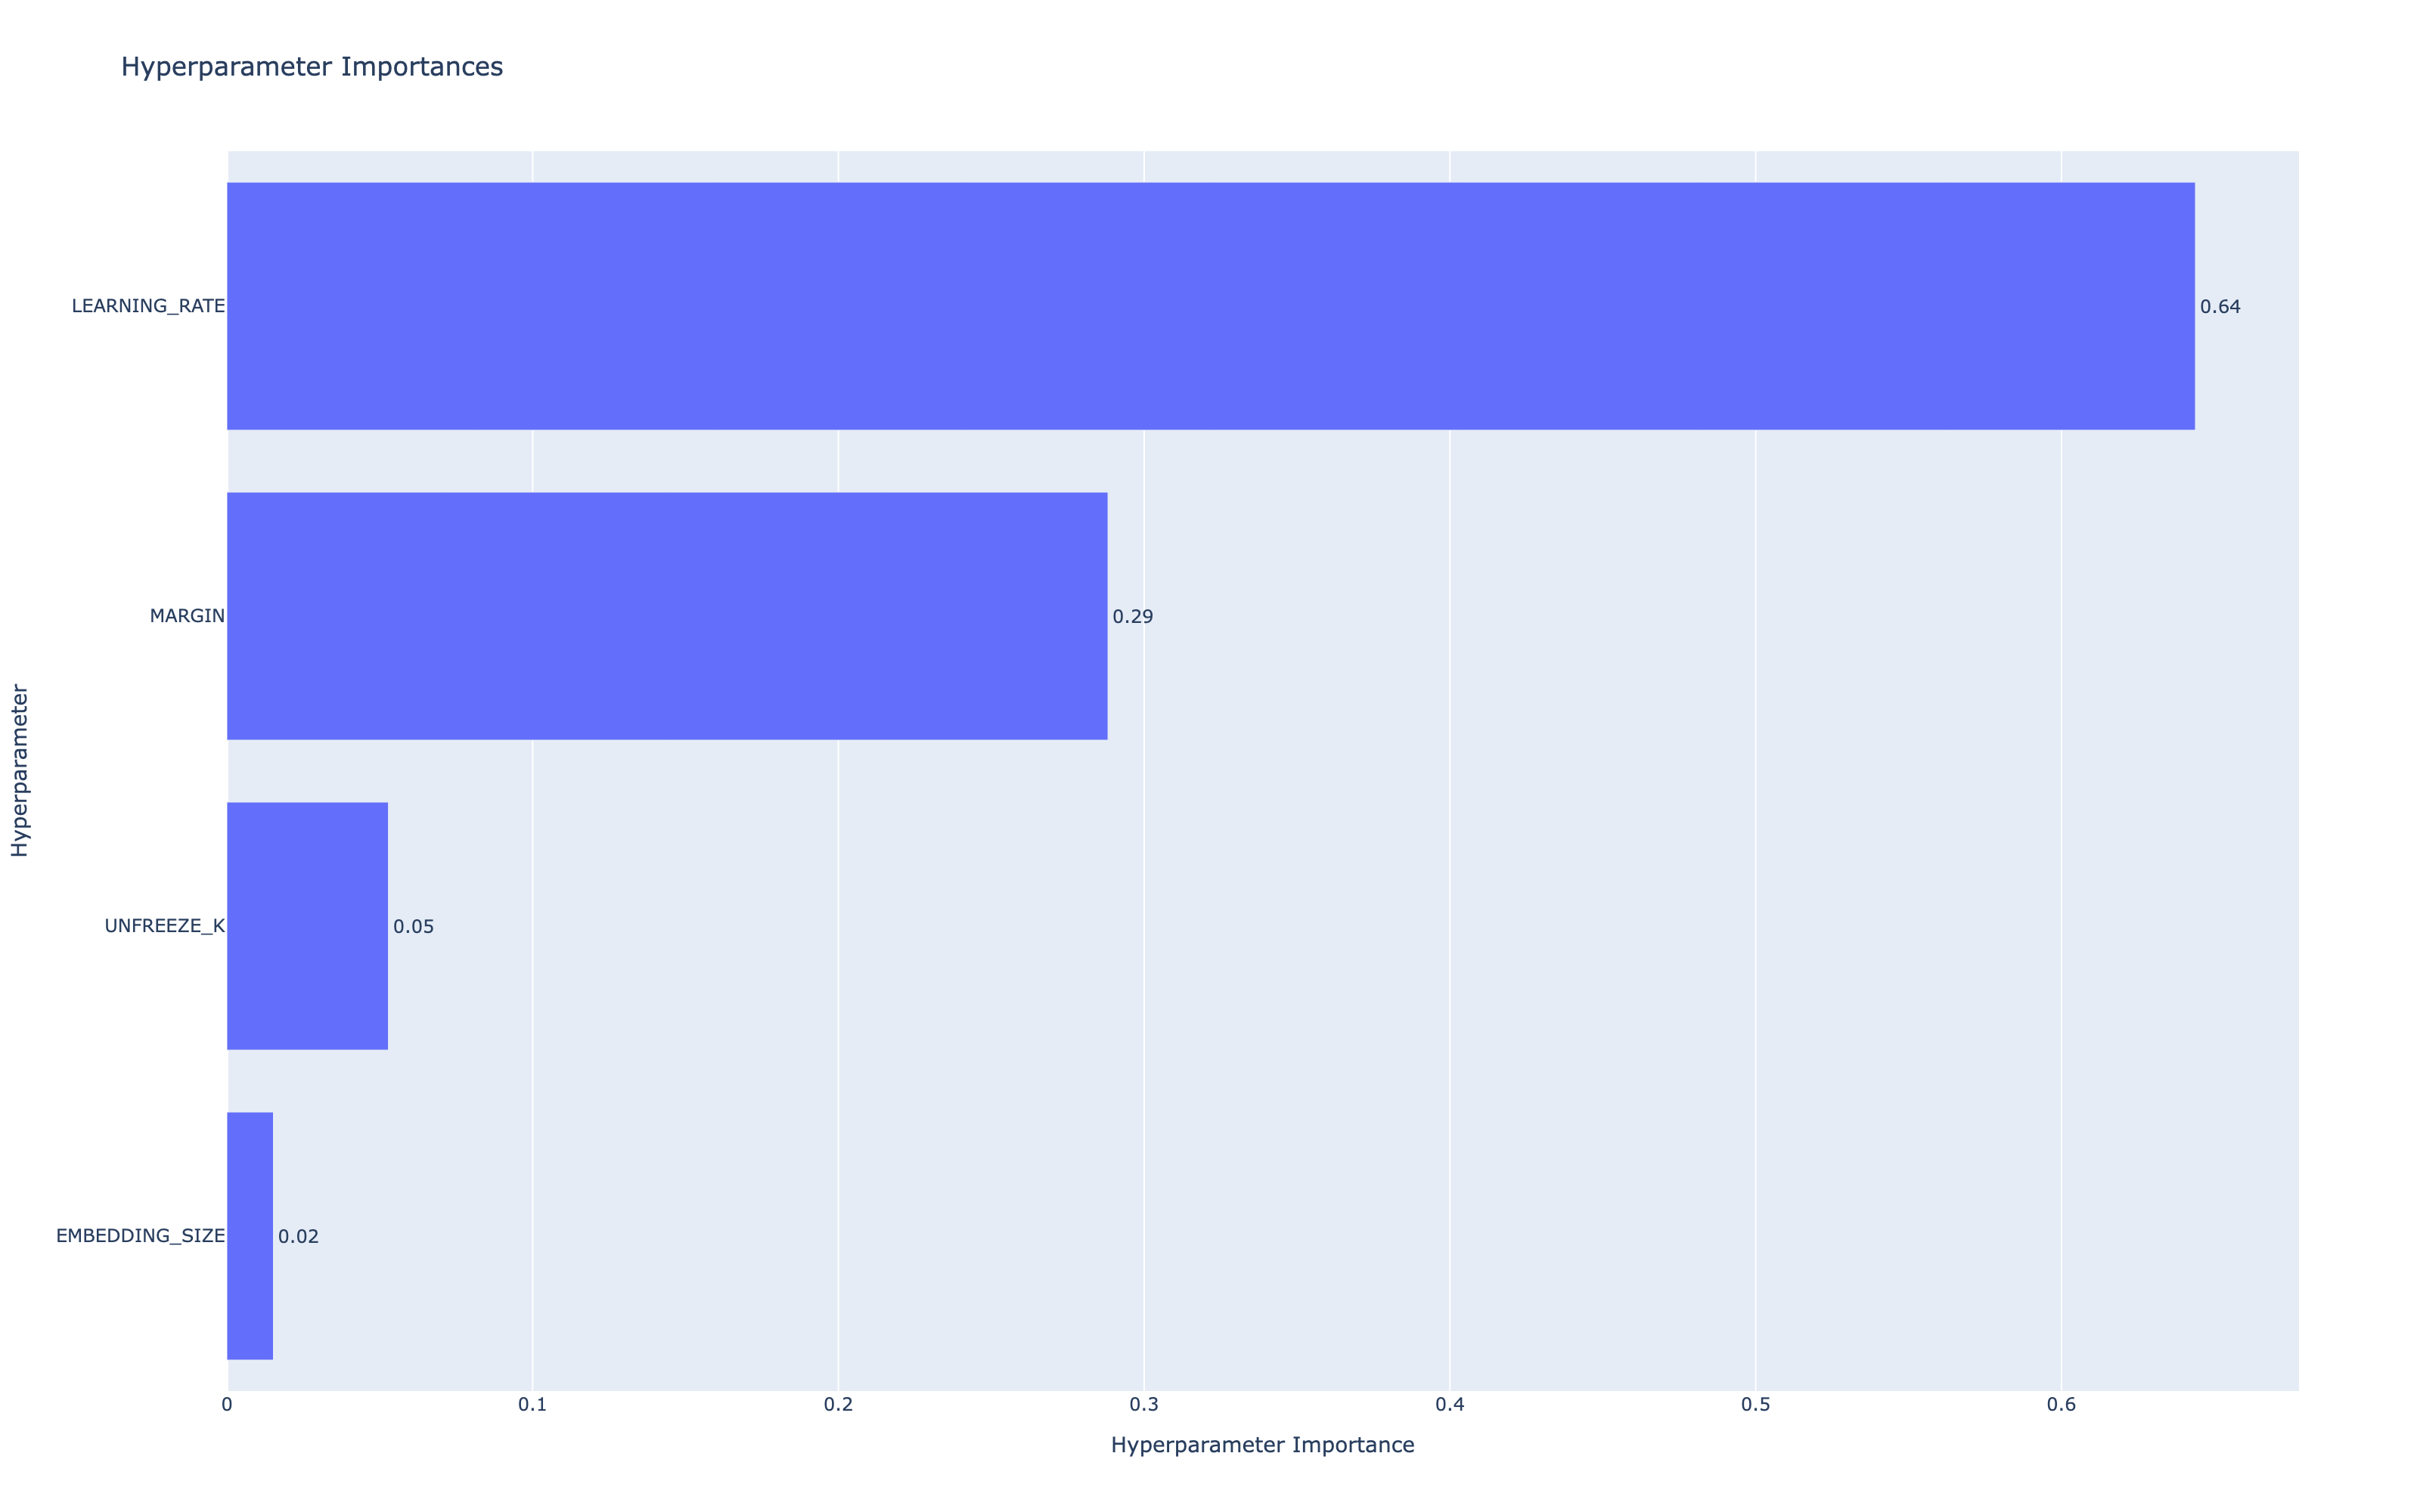

In [12]:
# Shows which hyperparameters were most important
fig = optuna.visualization.plot_param_importances(study, target_name="val_f1_macro")
file_path = os.path.join(output_dir, "metric-param-importances.png")
fig.write_image(file_path, width=1600, height=1000, scale=2)

Image(filename=file_path)

## 4. Conclusion

The best hyperparameters found during the search are saved and will be used to train the final metric learning model. The top-performing trial achieved a validation macro-F1 of 0.72 within one epoch.

In general, in most of the cases the training was terminated after one epoch by the early stopper triggered because of large gap between macro-F1 of val and train sets.

Optimal hyperparameters are saved and will be used for the final training.